In [61]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [62]:
# Additional libraries for text preprocessing and feature engineering
import re
from nltk.corpus import stopwords
import numpy as np

In [63]:
# Load dataset
df = pd.read_csv("../../Fake review detection dataset/Yelp Dataset Reduced.csv")

In [64]:
df.head()

,ID,USER_ID,PRODUCT_ID,RATING,DATE,LABEL,REVIEW_TEXT,AVERAGE_RATING,RATING_DEVIATION,TOTAL_PRODUCT_REVIEWS,...,RATING_CATEGORY,SINGLE_RATING_CATEGORY,REVIEW_COUNT_DATE,SAME_DATE_MULTIPLE_REVIEWS,MAX_USER_REVIEWS_DAY,TIMESTAMP_DIFFERENCE,AVERAGE_USER_REVIEW_LENGTH,TOTAL_USER_REVIEWS,PERCENTAGE_POSITIVE_REVIEWS,RATIO_POSITIVE_NEGATIVE
0,144828,66563,416,4,10-12-2014,-1,Great.....,3.767293,0.232707,2183,...,1,1,1,0,2,0 days,11.500000,2,100.0,6.157377
1,157607,74755,449,4,26-03-2013,1,My family and I had Bubby's brunch on a Saturd...,3.396552,0.603448,812,...,1,1,2,0,2,1723 days,724.666667,12,100.0,3.121827
2,70401,49165,237,3,11-10-2011,1,"I really like this place, but they need to get...",3.799003,0.799003,602,...,1,1,2,0,1,0 days,314.000000,1,100.0,6.082353
3,124810,75653,363,5,14-01-2014,1,This is one of my favorite places in the US. A...,3.990361,1.009639,2075,...,1,1,1,0,1,0 days,280.000000,1,100.0,9.121951
4,42068,32402,100,4,02-12-2014,1,Make sure you go with a small group of friends...,3.951812,0.048188,2677,...,1,1,2,0,1,398 days,255.666667,3,100.0,8.734545


In [65]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special characters
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespace
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])    
    return text

df["REVIEW_TEXT"] = df["REVIEW_TEXT"].apply(preprocess_text)

In [66]:
df.rename(columns = {'Unnamed: 0':'ID'}, inplace = True)
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].str.replace(' days', '')
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].astype(int)
num_features = df.drop(['ID','USER_ID','PRODUCT_ID','DATE','REVIEW_TEXT','LABEL'],axis=1)

In [67]:
# Use TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["REVIEW_TEXT"])
y = df["LABEL"]  

In [68]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('X_train.shape:', X_train.shape)

print('X_test.shape', X_test.shape)

X_train.shape: (14955, 44623)
X_test.shape (4985, 44623)


In [69]:
# Oversampling with adasyn
adasyn = ADASYN(random_state=42)   #smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train )

In [70]:
# # Define a list to store individual Random Forest models
# random_forest_models = []

# # Define hyperparameters and subsets of data for each model
# params_list = [
#     {'n_estimators': 100, 'max_depth': 10},
#     {'n_estimators': 200, 'max_depth': 20},
#     {'n_estimators': 300, 'max_depth': 30}
# ]

# # Train a Random Forest model for each set of hyperparameters
# for params in params_list:
#     # Create and train the Random Forest model
#     rf_model = RandomForestClassifier(**params)
#     rf_model.fit(X_train_resampled, y_train_resampled)
    
#     # Append the trained model to the list
#     random_forest_models.append(rf_model)

# # Make predictions on the test set using each model
# predictions_list = [model.predict(X_test) for model in random_forest_models]

# # Evaluate each model individually
# for idx, predictions in enumerate(predictions_list):
#     print(f"Model {idx+1} Metrics:")
#     print(classification_report(y_test, predictions))

# # Ensemble predictions (e.g., voting)
# ensemble_predictions = [sum(pred) > len(pred) / 2 for pred in zip(*predictions_list)]

# # Evaluate the ensemble model
# print("Ensemble Model Metrics:")
# print(classification_report(y_test, ensemble_predictions))

In [74]:
# Random Forest Classifer
model = RandomForestClassifier(n_estimators=200, max_depth= 20, random_state=42)  
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [75]:
X_train_resampled.shape

(26698, 44623)

In [76]:
# Predict probabilities for test data
y_pred_proba = model.predict_proba(X_test)[:, 1]

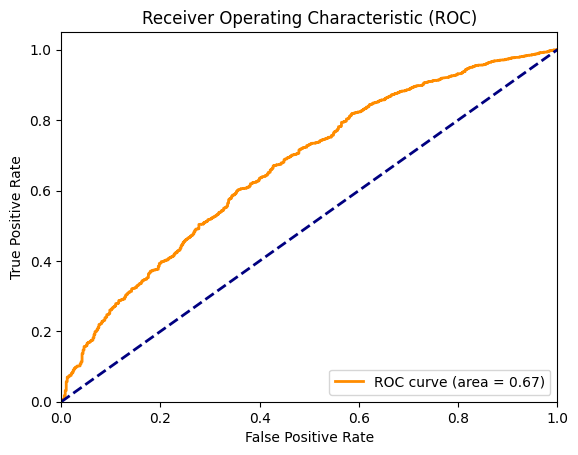

In [77]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [78]:
# Make predictions on the testing data
y_pred = model.predict(X_test)

In [79]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7867602808425276
Confusion Matrix:
 [[ 195  306]
 [ 757 3727]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.20      0.39      0.27       501
           1       0.92      0.83      0.88      4484

    accuracy                           0.79      4985
   macro avg       0.56      0.61      0.57      4985
weighted avg       0.85      0.79      0.81      4985



In [80]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print sensitivity and specificity
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

Sensitivity (True Positive Rate): 0.8311775200713648
Specificity (True Negative Rate): 0.38922155688622756
